Import Required Libraries and setting a seed for reproducibility. 

In [2092]:
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

Load Images and Labels.

In [2093]:
images = []
labels = []
for dir in Path("att_faces").iterdir():
    dir_name = dir.name
    try: # There is a hidden '.DS_Store' dir apparently, so to avoid errors relating to that.
        dir_index = int(dir_name[1:]) # Getting the label.
    except ValueError:
        continue
    for img in Path(f"att_faces/{dir.name}").iterdir():
        labels.append(dir_index) # Storing labels.
        image = Image.open(img)
        images.append(np.array(image).flatten()) # Storing images.

images = np.array(images).T # Transposing to make it such that the images are in columns.
labels = np.array(labels)


# Getting some non-face images for recognition/clasification.
count = 2445 
non_face_paths = []
for img in Path("non_faces").iterdir():
    non_face_paths.append(img)

non_face_paths = np.array(non_face_paths)
non_face_paths_trunc = non_face_paths[(np.random.choice(len(non_face_paths), count, replace = False))]
non_face_img = [] 
for img in non_face_paths_trunc:
    image = Image.open(img)
    image = image.convert('L') # Converting to grayscale.
    image = image.resize((112, 92)) 
    non_face_img.append(np.array(image).flatten())

non_face_img = np.array(non_face_img).T

combined_img = np.concatenate((images,non_face_img), axis = 1)

Mean Center the data.

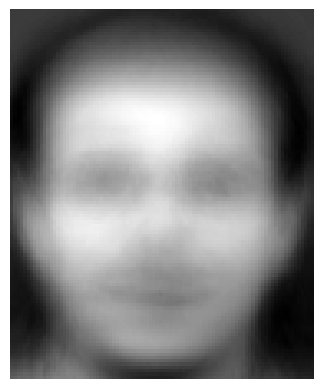

In [2094]:
mean = np.mean(images, axis = 1) # Mean along the rows as those are the "dimension means".
images_centered = (images.T - mean).T 

# mean centering combined images.
mean_combined = np.mean(combined_img, axis = 1)
combined_img_centered = (combined_img.T - mean_combined).T

faces_centered_combined = (images.T - mean_combined).T
non_faces_centered_combined = (non_face_img.T - mean_combined).T

# Visualizing the "mean" face.
plt.imshow(mean.reshape((112, 92)), cmap = 'gray')
plt.axis('off')
plt.show()

Getting the orthogonal eigenvectors of X @ X_T (where X is the mean centered data) via SVD of X. The left singular vectors of X are (by definition) the orthogonal eigenvectors of X @ X_T and the square of the singular values are the eigenvalues of X @ X_T.

In [2095]:
# full_matrices = False only gives > 0 eigenvalues and their corresponding eigenvectors.
# Our image matrix may not have full rank, that is, there could be some dimensions that 
# are linear combinations of others. We get rid of those as they are redundant. 
eigvecs, eigvals, _ = np.linalg.svd(images_centered, full_matrices = False)

# SVD of combined images.
eigvecs_combined, eigvals_combined, _ = np.linalg.svd(combined_img_centered, full_matrices = False)


Visualizing (the most important 10) eigenfaces.

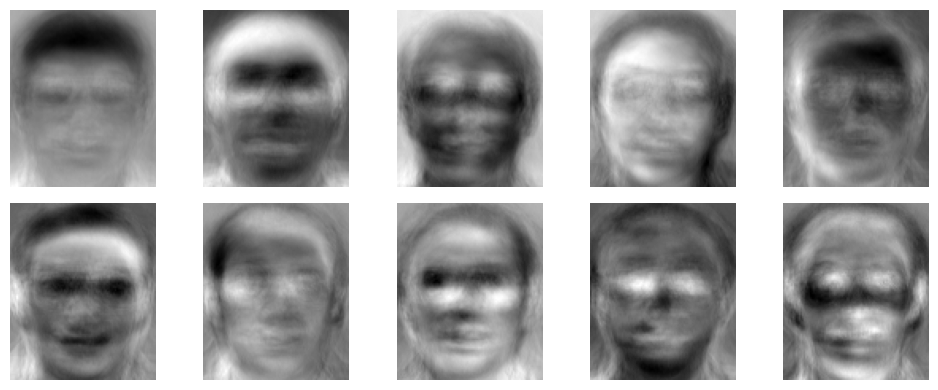

In [2096]:
imp_faces = []
for i in range(0, 10):
    imp_faces.append(eigvecs[:, i].reshape((112, 92)))

imp_faces = np.array(imp_faces)

fig, axarr = plt.subplots(2, 5, figsize = (10, 4))
axarr_flat = axarr.flatten()

for i, img in enumerate(imp_faces):
    axarr_flat[i].imshow(img, cmap = 'gray')
    axarr_flat[i].axis('off')

plt.tight_layout()
plt.show()

Cumulative sum of eigenvalues (variances) plot. TODO: 

1.) Seems like the cumulative sum goes up exponentially up until a certain point when it starts getting 0 eigenvalues. Why is this? Any analytical reasons? <br>
2.) Plot both the log graph and the non-log version. The log version is good to show that the increase is basically exponential until the plateau. <br>
3.) Could also plot the descending eigenvalues in the Csum plot. <br>

298 is the least number of principal components that explains 90% of the variance.


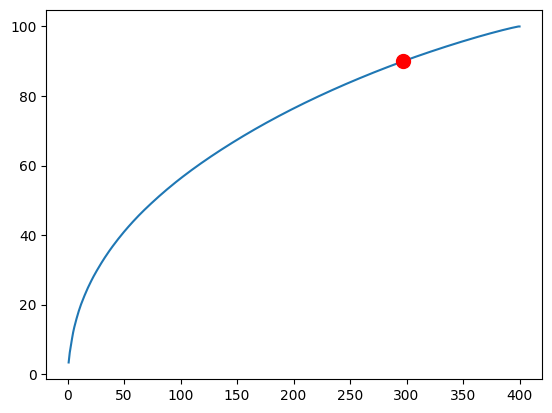

In [2097]:
per = (np.cumsum(eigvals) / np.sum(eigvals)) * 100 # Percentage of variance explained.

num_dim = np.argmax(per >= 90) + 1 # The least number of principal components that explains 90% of the variance.
print(f"{num_dim} is the least number of principal components that explains 90% of the variance.")

plt.plot([i for i in range(1, len(eigvals) + 1)], per)
plt.plot(num_dim - 1, per[num_dim - 1], marker = 'o', markersize = 10, color = 'red')

plt.show()

Reconstruction. Note that if you iterate over all possible number of principal components used, the complexity is O(num_pixes^3), and num_pixels is like 10000, so this would take forever. 

Error using the first 298 eigenfaces: 22.45837835345196


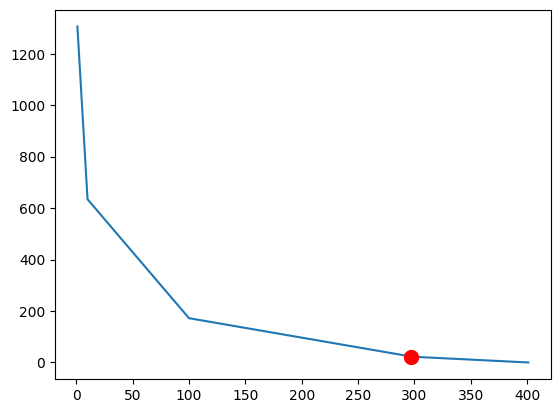

In [2098]:
num_sample = 80
# Picking 80 random images from the dataset.
img_subset = images_centered.T[np.random.choice(images_centered.shape[1], num_sample, replace = False)].T
pc_grid = [1, 10, 100, num_dim, 401] # We have to use a grid as the program would take forever to halt 
                                         # if we went through all values from 1 to 10304. (complexity would be N^3).
                                         # 10304^3 is very (very) large.

mse_array = []
with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'):
    for i in pc_grid:
        pc = (eigvecs.T)[0:i, :] # principal components up to i.
        #print(pc)
        rep = pc @ img_subset # representation
        rec = pc.T @ rep # reconstruction

        mse = (np.square(img_subset - rec).mean(axis = 1)).mean() # mse error of reconstruction averaged over number of features
        mse_array.append(mse)


print(f"Error using the first {num_dim} eigenfaces: {mse_array[3]}")
plt.plot(pc_grid, mse_array)
plt.plot(num_dim - 1, mse_array[3], marker = 'o', markersize = 10, color = 'red')
plt.show()

Dividing into train and test set for face recognition. 8 images from 35 subjects are randomly chosen (both the subjects and the images from each subject are randomly picked) to form the train set. And the remaining images form the test set. <br>

In [2099]:
np.random.seed(7) # For reproducibility.

# 80-20 split for non-face images.
def random_split_non_face():
    train_images = []
    test_images = []

    random_indices = np.random.permutation(400)

    for i in random_indices:
        if len(train_images) < 280:
            train_images.append(non_faces_centered_combined.T[i])
        else:
            test_images.append(non_faces_centered_combined.T[i])

    train_images = np.array(train_images).T
    test_images = np.array(test_images).T

    # labels are all 2 for non-face images.
    train_labels = np.array([2.] * train_images.shape[1])
    test_labels = np.array([2.] * test_images.shape[1])

    return train_images, train_labels, test_images, test_labels

def random_split_face():
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    num_subjects = 0
    count = np.zeros(40)

    # for randomization
    random_indices = np.random.permutation(400)

    # code to divide the images as per instructions into train and test sets. 
    # NOTE: I definitely can write this better, but it works so will bother with it later.
    for i in random_indices:
        if num_subjects < 35:
            if count[labels[i] - 1] < 8:
                if count[labels[i] - 1] == 0:
                    num_subjects += 1
                train_images.append(faces_centered_combined.T[i])
                train_labels.append(labels[i])
                count[labels[i] - 1] += 1
            else:
                test_images.append(faces_centered_combined.T[i])
                test_labels.append(labels[i])
        else:
            if count[labels[i] - 1] > 0 and count[labels[i] - 1] < 8:
                train_images.append(faces_centered_combined.T[i])
                train_labels.append(labels[i])
                count[labels[i] - 1] += 1
            else:
                test_images.append(faces_centered_combined.T[i])
                test_labels.append(labels[i])

    train_images = np.array(train_images).T
    train_labels = np.array(train_labels)
    test_images = np.array(test_images).T
    test_labels = np.array(test_labels)

    return train_images, train_labels, test_images, test_labels

Linear Discriminant Analysis for Face Recognition.

In [2103]:
average_accuracy = 0
accuracies = []
num_trials = 5 

for i in range(num_trials):
    face_train_img, _, face_test_img, _ = random_split_face()
    non_face_train_img, _, non_face_test_img, non_face_test_labels = random_split_non_face()

    with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'):
        # representation of face images in the PCA basis.
        face_train_img = (eigvecs_combined.T)[0:3, :] @ face_train_img
        face_test_img = (eigvecs_combined.T)[0:3, :] @ face_test_img

        # represenation of non-face images in the PCA basis.
        non_face_train_img = (eigvecs_combined.T)[0:3, :] @ non_face_train_img
        non_face_test_img = (eigvecs_combined.T)[0:3, :] @ non_face_test_img

    # basis expansion
    face_train_img = np.concatenate((face_train_img, face_train_img ** 2), axis = 0)
    face_test_img = np.concatenate((face_test_img, face_test_img ** 2), axis = 0)
    non_face_train_img = np.concatenate((non_face_train_img, non_face_train_img ** 2), axis = 0)
    non_face_test_img = np.concatenate((non_face_test_img, non_face_test_img ** 2), axis = 0)

    # LDA
    num_face_train = face_train_img.shape[1]
    num_non_face_train = non_face_train_img.shape[1]
    total_train = num_face_train + num_non_face_train

    # priors for each class.
    pi = np.array([num_face_train / total_train, num_non_face_train / total_train])

    # means.
    mean_train_face = np.mean(face_train_img, axis = 1).reshape(-1, 1)
    mean_train_non_face = np.mean(non_face_train_img, axis = 1).reshape(-1, 1)

    # mean_centered.
    centered_face_train = face_train_img - mean_train_face
    centered_non_face_train = non_face_train_img - mean_train_non_face

    # calculate sigma and its inverse.
    sigma = (centered_face_train @ centered_face_train.T + centered_non_face_train @ centered_non_face_train.T) / (total_train - len(pi))
    sigma_inv = np.linalg.inv(sigma)

    # calculate slope and intercept.
    a = sigma_inv @ (mean_train_face - mean_train_non_face)
    b = np.log(pi[0] / pi[1]) - ((1 / 2) * ((mean_train_face + mean_train_non_face).T @ a))

    # classifying test images.
    res_face = face_test_img.T @ a + b
    res_non_face = non_face_test_img.T @ a + b

    print(np.sum(res_face > 0) / face_test_img.shape[1])
    print(np.sum(res_non_face < 0) / non_face_test_img.shape[1])
    print('\n')

0.9583333333333334
0.9166666666666666


0.9583333333333334
0.9166666666666666


0.9666666666666667
0.9083333333333333


0.95
0.8916666666666667


0.9166666666666666
0.9583333333333334




Face Recognition using Linear Regression. TODO:

1.) LDA might be better. Implement that. And think of a principled reason why just linear regression doesn't work. We could mention this in the report and talk about it in the presentation.

In [2101]:
"""average_accuracy = 0
accuracies = []
num_trials = 20 

for i in range(num_trials):
    face_train_img, _, face_test_img, _ = random_split_face()
    non_face_train_img, _, non_face_test_img, non_face_test_labels = random_split_non_face()

    # representation of face images in the PCA basis.
    face_train_img = (eigvecs.T)[0:1, :] @ face_train_img
    face_test_img = (eigvecs.T)[0:1, :] @ face_test_img

    # represenation of non-face images in the PCA basis.
    non_face_train_img = (eigvecs_non_face.T)[0:1, :] @ non_face_train_img
    non_face_test_img = (eigvecs_non_face.T)[0:1, :] @ non_face_test_img

    # combining the the face and non-face representations for train and test.
    rec_train_rep = np.concatenate((face_train_img, non_face_train_img), axis = 1)
    rec_test_rep = np.concatenate((face_test_img, non_face_test_img), axis = 1)

    # Creating labels for the face and non-face train images in 0-1 encoding.
    rec_labels_face = np.tile(np.array([1., 0.]), (280, 1))
    rec_labels_non_face = np.tile(np.array([0., 1.]), (160, 1))
    rec_train_labels = np.concatenate((rec_labels_face, rec_labels_non_face), axis = 0)
    rec_train_labels = rec_train_labels.T

    # labels for the face and non-face test images where 1 is face and 2 is non-face.
    face_test_labels = np.array([1.] * face_test_img.shape[1])
    rec_test_labels = np.concatenate((face_test_labels, non_face_test_labels), axis = 0)

    # Polynomial feature expansion of degree 3 before classification. Remember that the first axis consists of dimension values
    # of the data points.
    rec_train_rep = np.concatenate((rec_train_rep, rec_train_rep ** 2), axis = 0)
    rec_test_rep = np.concatenate((rec_test_rep, rec_test_rep ** 2), axis = 0)

    # getting the weights for linear regression.
    #print(rec_train_labels.shape, rec_train_rep.T.shape)
    W = rec_train_labels @ rec_train_rep.T @ np.linalg.inv(rec_train_rep @ rec_train_rep.T)
    
    test_outputs = (W @ rec_test_rep).T

    # classifying the outputs.
    test_outputs_standard = np.array([])
    for el in test_outputs:
        test_outputs_standard = np.append(test_outputs_standard, np.argmax(el) + 1)

    print(rec_test_labels)
    print(test_outputs_standard)
    sum = 0
    for j in range(test_outputs_standard.size):
        if test_outputs_standard[j] == rec_test_labels[j]:
            sum += 1

    accuracies.append((sum / test_outputs_standard.size) * 100)

average_accuracy = np.mean(accuracies)
standard_deviation = np.std(accuracies)
print(f"Average accuracy over {num_trials} random splits: {average_accuracy} %")
print(f"Standard deviation of accuracy over {num_trials} random splits: {standard_deviation} %")"""

'average_accuracy = 0\naccuracies = []\nnum_trials = 20 \n\nfor i in range(num_trials):\n    face_train_img, _, face_test_img, _ = random_split_face()\n    non_face_train_img, _, non_face_test_img, non_face_test_labels = random_split_non_face()\n\n    # representation of face images in the PCA basis.\n    face_train_img = (eigvecs.T)[0:1, :] @ face_train_img\n    face_test_img = (eigvecs.T)[0:1, :] @ face_test_img\n\n    # represenation of non-face images in the PCA basis.\n    non_face_train_img = (eigvecs_non_face.T)[0:1, :] @ non_face_train_img\n    non_face_test_img = (eigvecs_non_face.T)[0:1, :] @ non_face_test_img\n\n    # combining the the face and non-face representations for train and test.\n    rec_train_rep = np.concatenate((face_train_img, non_face_train_img), axis = 1)\n    rec_test_rep = np.concatenate((face_test_img, non_face_test_img), axis = 1)\n\n    # Creating labels for the face and non-face train images in 0-1 encoding.\n    rec_labels_face = np.tile(np.array([1., 

Face Identification using Linear Regression.

In [2102]:
"""iden_labels = [] 
for i in range(0, len(train_labels)):
    label = np.zeros(35)
    label[train_labels[i] - 1] = 1
    iden_labels.append(label)

iden_labels = np.array(iden_labels)
iden_labels = iden_labels.T

# Doing change of basis of the train and test images using the the first 399 eigenfaces
# as they are the most informative as per above experiments. 
proj_train_data = (eigvecs.T)[0:num_dim, :] @ train_images 
proj_test_data = (eigvecs.T)[0:num_dim, :] @ test_images 

with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'):
    W = iden_labels @ proj_train_data.T @ np.linalg.inv(proj_train_data @ proj_train_data.T)

    test_outputs = (W @ proj_test_data).T

test_outputs_standard = np.array([])
for el in test_outputs:
    test_outputs_standard = np.append(test_outputs_standard, np.argmax(el) + 1)

print(test_labels)
print(test_outputs_standard)

mse = np.mean((test_outputs_standard - test_labels)**2)"""
mse

np.float64(3.931102498409377e-26)